<a href="https://colab.research.google.com/github/KenzaB27/BGNHackathon2021/blob/machine_learning/machine_learning/alphanum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environement setup

In [1]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!echo '{"username":"kenzabouzid","key":"7fa6e6d68e8f429177c6eb453105e3c1"}' > /root/.kaggle/kaggle.json
!chmod 600  /root/.kaggle/kaggle.json
!kaggle datasets download -d kuzivakwashe/significant-asl-sign-language-alphabet-dataset
!unzip /content/significant-asl-sign-language-alphabet-dataset.zip -d significant-asl-sign-language-alphabet-dataset

In [5]:
from tensorflow import keras
from tqdm import tqdm
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential, load_model, Model

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
tf.random.set_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

import os

# Preprocessing

In [6]:
# Set global variables
TRAIN_DIR = '/content/significant-asl-sign-language-alphabet-dataset/significant-asl-alphabet-training-set/Training Set'
TEST_DIR = '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
# CUSTOM_TEST_DIR = '/content/asl-alphabet-test/asl-alphabet-test/'

IMG_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_DIMS = (IMG_SIZE, IMG_SIZE, 3) # add channel for RGB
N_CLASSES = 27
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

# Model saving for easier local iterations
MODEL_DIR = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = True


In [7]:
CATEGORIES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CATEGORIES.sort()

print('Following classes were found:')
print(', '.join(CATEGORIES))

Following classes were found:
A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, space


(134, 109, 3)
(134, 72, 3)
(102, 80, 3)
(175, 130, 3)
(146, 113, 3)
(154, 84, 3)
(93, 156, 3)
(152, 136, 3)
(136, 98, 3)
(640, 640, 3)
(167, 73, 3)
(178, 124, 3)
(147, 79, 3)
(169, 84, 3)
(120, 109, 3)
(80, 93, 3)
(240, 320, 3)
(200, 200, 3)
(173, 148, 3)
(151, 133, 3)
(139, 82, 3)
(149, 75, 3)
(127, 75, 3)
(158, 82, 3)
(126, 119, 3)
(200, 200, 3)
(200, 200, 3)


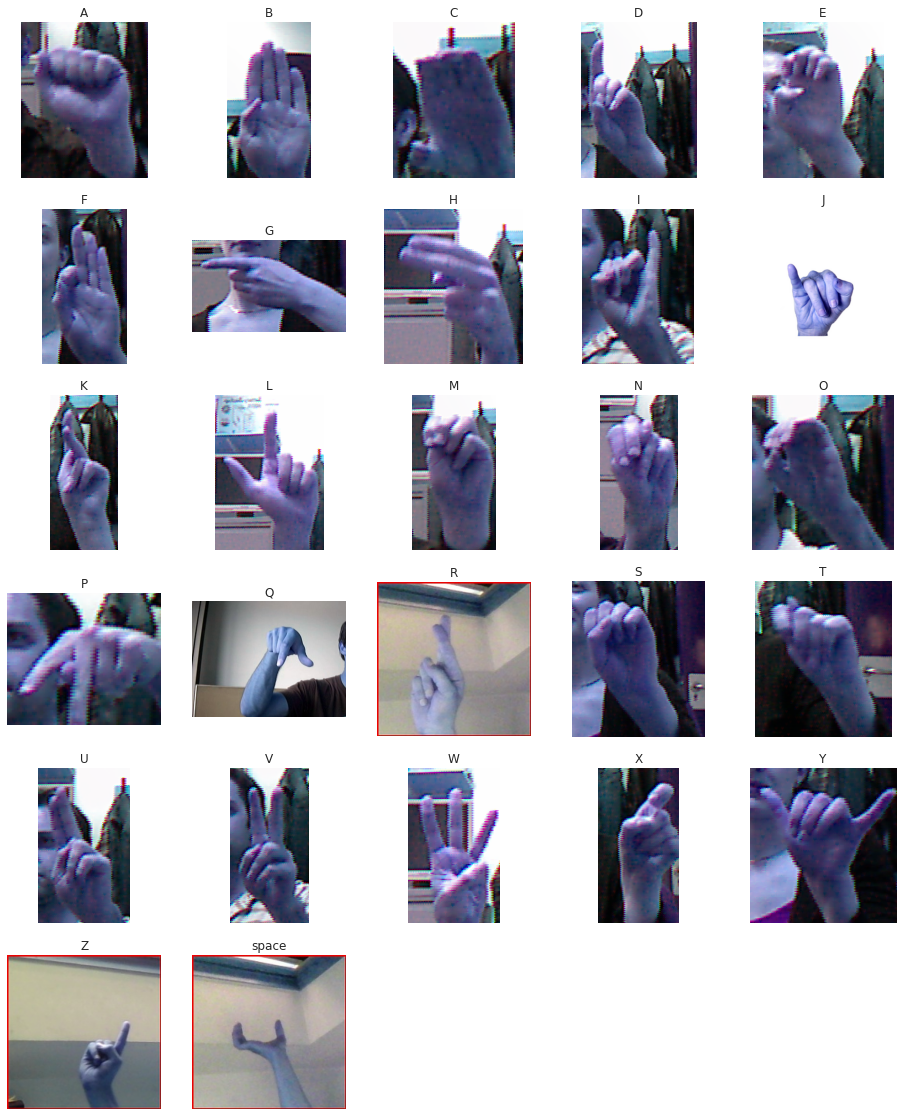

In [8]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CATEGORIES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CATEGORIES)):
        cls = CATEGORIES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        im = cv2.imread(imgs[0])
        print(im.shape)
        plt.imshow(im)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each(TRAIN_DIR)

## Test and Training Data



In [14]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(TRAIN_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████| 3000/3000 [00:02<00:00, 1389.13it/s]


In [15]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])

4
24
17
2
10
20
0
24
25
21


In [18]:
test_data = training_data[76490:]
len(test_data)

1000

In [19]:
training_data = training_data[:76490]
len(training_data)

76490

## Split labels and features

In [20]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

np.save(MODEL_DIR+"X.npy", X)
np.save(MODEL_DIR+"Y.npy", Y)


(76490, 64, 64, 3)
(76490,)


# Build Model

Need to reprocess? True


In [21]:
# with tpu_strategy.scope():

model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',input_shape=TARGET_DIMS,activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(N_CLASSES,activation="softmax"))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

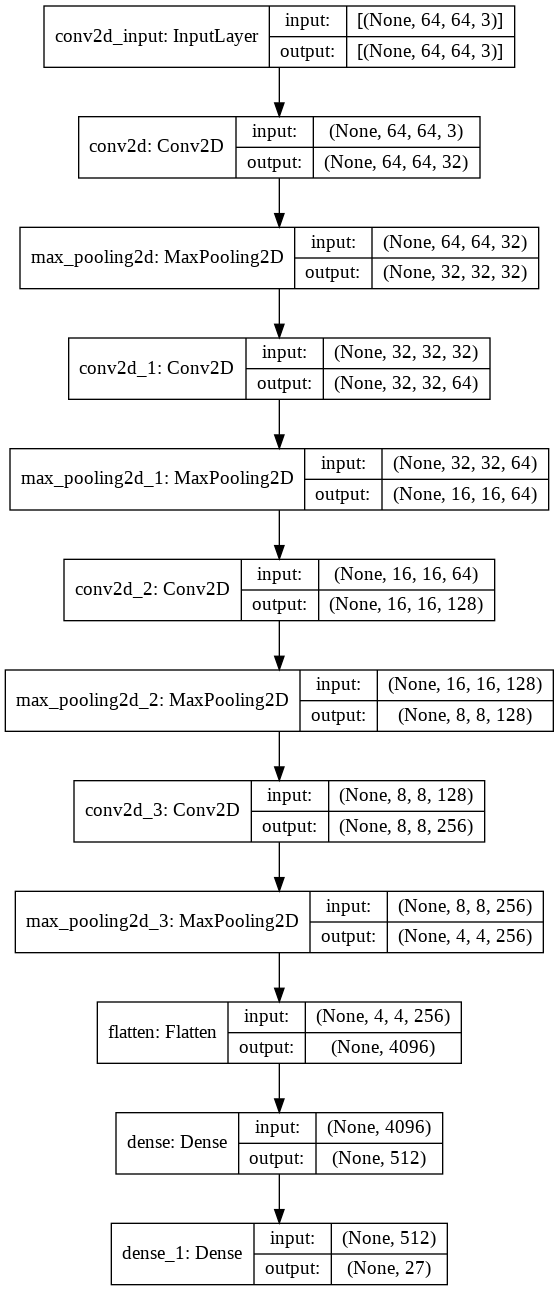

In [23]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)
with tf.device('/device:GPU:0'):
  history = model.fit(X, Y, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
1913/1913 [==============================] - 47s 7ms/step - loss: 2.3173 - accuracy: 0.6382 - val_loss: 0.3095 - val_accuracy: 0.9114

Epoch 00001: val_accuracy improved from -inf to 0.91136, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5
Epoch 2/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.2635 - accuracy: 0.9215 - val_loss: 0.3240 - val_accuracy: 0.9114

Epoch 00002: val_accuracy improved from 0.91136 to 0.91143, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5
Epoch 3/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1916 - accuracy: 0.9431 - val_loss: 0.1774 - val_accuracy: 0.9476

Epoch 00003: val_accuracy improved from 0.91143 to 0.94764, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5
Epoch 4/20
1913/1913 [==============================] - 13s 7ms/step - loss: 0.1491 - accuracy: 0.9550 - val_loss: 0.1793 - val_accuracy: 0

In [25]:
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5'
model.load_weights(checkpoint_filepath)
model.save_weights(checkpoint_filepath)

## Evaluate model

In [36]:
len(test_data)

1000

In [38]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

np.save(MODEL_DIR+"X_test.npy", X_test)
np.save(MODEL_DIR+"Y_test.npy", Y_test)


(1000, 64, 64, 3)
(1000,)


In [39]:
loss,acc = model.evaluate(X_test,Y_test)
print(f"Accuracy: {acc*100}")
print(f"Loss: {loss}")

32/32 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9750
Accuracy: 97.50000238418579
Loss: 0.12040971219539642


In [49]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.975

In [50]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        37
           1       1.00      1.00      1.00        45
           2       1.00      0.89      0.94        38
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        34
           5       1.00      1.00      1.00        33
           6       0.98      0.92      0.95        49
           7       0.93      0.95      0.94        42
           8       1.00      0.92      0.96        48
           9       0.00      0.00      0.00         0
          10       0.98      1.00      0.99        41
          11       0.94      0.97      0.96        34
          12       0.98      0.98      0.98        41
          13       0.95      1.00      0.98        40
          14       0.97      1.00      0.99        38
          15       0.94      0.97      0.96        34
          16       0.97      0.97      0.97        35
          17       0.98    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip /content/asl-alphabet.zip -d asl-alphabet

In [40]:
import cv2
def test_model(path, model):

  im = cv2.imread(path)

  im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))
  im = im.reshape(1,IMG_SIZE,IMG_SIZE,3)

  plt.imshow(im[0])
  plt.show()
  res = model.predict(im)
  return np.argmax(res)

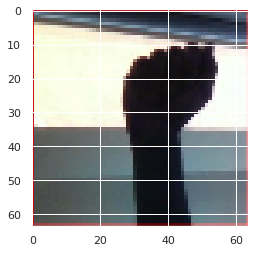

0


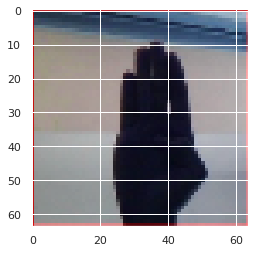

1


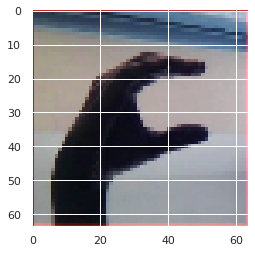

2


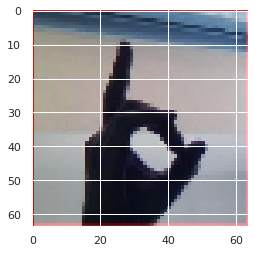

3


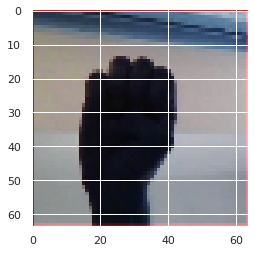

4


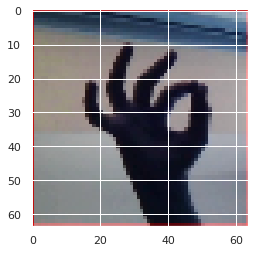

5


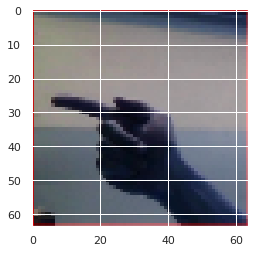

6


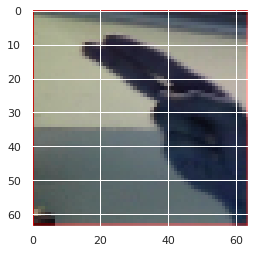

7


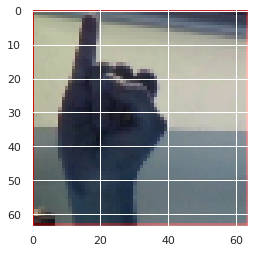

8


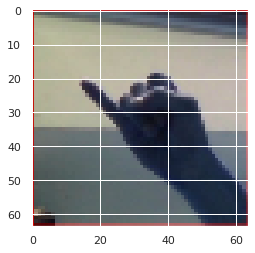

6


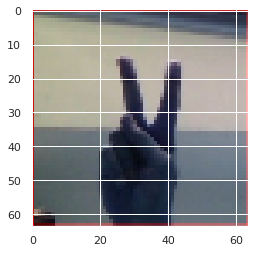

21


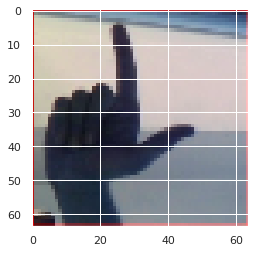

11


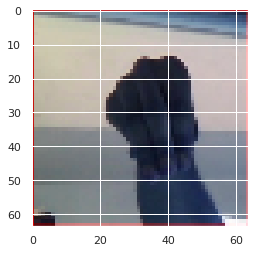

13


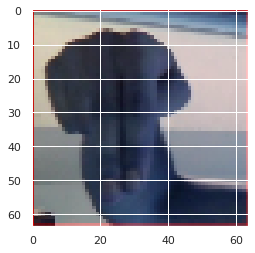

13


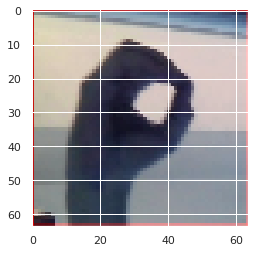

24


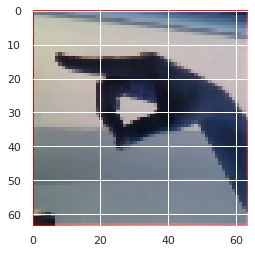

15


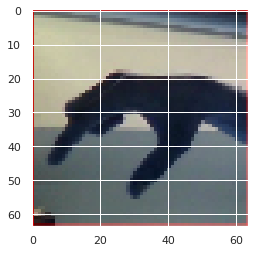

15


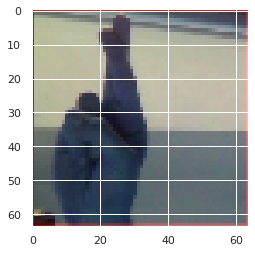

17


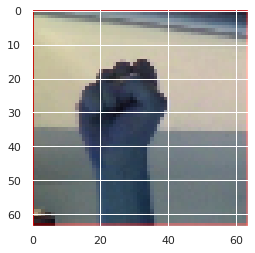

13


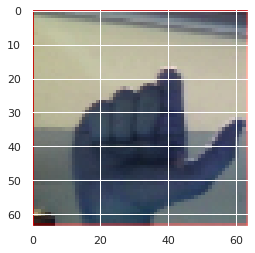

13


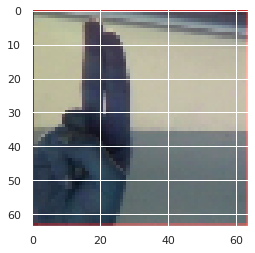

22


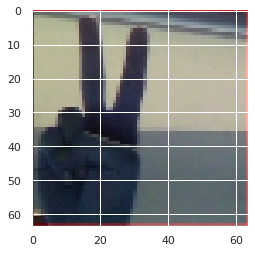

22


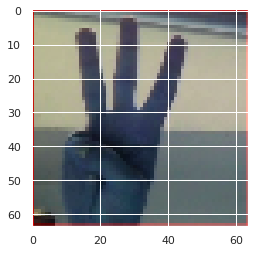

8


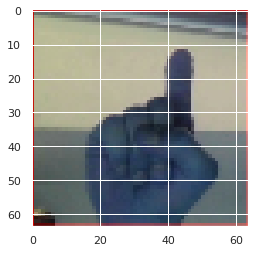

11


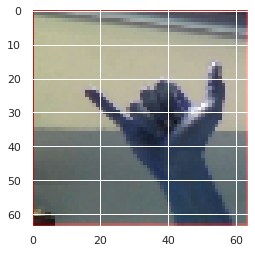

24


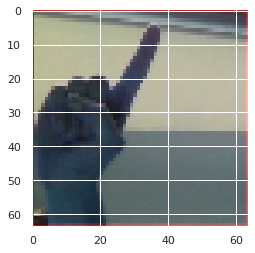

25


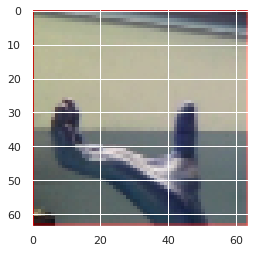

6
15


In [41]:
count = 0
for i, cat in enumerate(CATEGORIES):
  path = TEST_DIR + cat + "_test.jpg"
  prediction = test_model(path, model)
  if i == prediction: 
    count += 1 
  print(prediction)

print(count)

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(f'{checkpoint_filepath[:-2]}tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbgtw16_i/assets
